In [26]:
# Manipulação e Visualização de Dados
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Scikit-Learn
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score, recall_score, classification_report
from scipy.stats import ks_2samp

import optuna

In [27]:
df_train = pd.read_csv('../data/DF_TRAIN.csv')
df_val = pd.read_csv('../data/DF_VAL.csv')
df_test = pd.read_csv('../data/DF_TEST.csv')

In [28]:
TARGET = "Churn"

X_train, y_train = df_train.drop(columns=[TARGET]), df_train[TARGET]
X_val,   y_val   = df_val.drop(columns=[TARGET]),   df_val[TARGET]
X_test,  y_test  = df_test.drop(columns=[TARGET]),  df_test[TARGET]

In [29]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_val)
print("Acurácia Random Forest (validação):", accuracy_score(y_val, rf_preds))

# MLPClassifier
mlp_model = MLPClassifier(random_state=42,max_iter=1000)
mlp_model.fit(X_train, y_train)
mlp_preds = mlp_model.predict(X_val)
print("Acurácia MLP (validação):", accuracy_score(y_val, mlp_preds))

# XGBoost
from xgboost import XGBClassifier

xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_val)
print("Acurácia XGBoost (validação):", accuracy_score(y_val, xgb_preds))

Acurácia Random Forest (validação): 0.7799337434926644
Acurácia MLP (validação): 0.7799337434926644
Acurácia XGBoost (validação): 0.7870326549929011


In [30]:
def compute_metric(metric, y_true, probs, preds):
    """
    Calcula o score de acordo com a métrica escolhida.
    
    Parâmetros:
      - metric: string ('ks', 'roc', 'accuracy', 'f1', 'recall')
      - y_true: valores reais
      - probs: probabilidades preditas (usadas para KS e ROC-AUC)
      - preds: classes preditas (usadas para acurácia, F1 e recall)
      
    Retorna:
      - Valor da métrica escolhida.
    """
    if metric == 'ks':
        return ks_2samp(probs[y_true == 1], probs[y_true == 0]).statistic
    elif metric == 'roc':
        fpr, tpr, thresholds = roc_curve(y_true, probs)
        return auc(fpr, tpr)
    elif metric == 'accuracy':
        return accuracy_score(y_true, preds)
    elif metric == 'f1':
        return f1_score(y_true, preds)
    elif metric == 'recall':
        return recall_score(y_true, preds)
    else:
        raise ValueError("Métrica não suportada. Escolha entre 'ks', 'roc', 'accuracy', 'f1' ou 'recall'.")
    
PARAM_SPACE = {
    "rf": {
        "n_estimators":           (50, 300,    "int"),
        "max_depth":              (2, 80,     "int_log"),
        "min_samples_split":      (2, 20,     "int"),
        "min_samples_leaf":       (1, 20,     "int"),
        "max_features":           (0.1, 1.0,  "float"),
        "bootstrap":              [True, False],
        "criterion":              ["gini", "entropy"],
    },
    "mlp": {
        "hidden_layer_sizes":     [(50,), (100,), (50, 50), (100, 50), (100, 100)],
        "activation":             ["relu", "tanh", "logistic"],
        "solver":                 ["adam", "sgd"],
        "alpha":                  (1e-5, 1e-2,    "float_log"),
        "learning_rate_init":     (1e-7, 1e-1,    "float_log"),
        "batch_size":             ["auto", 8, 16, 32, 64, 128],
        "max_iter":               [ 500, 1000,1300,1500,2000],
        "momentum":               (0.0, 0.99,     "float"),
        "learning_rate":          ["constant", "invscaling", "adaptive"],
        "tol":                    (1e-5, 1e-2,    "float_log"),
    },
    "xgb": {
        "n_estimators":           (50, 300,    "int"),
        "max_depth":              (2, 10,     "int_log"),
        "learning_rate":          (1e-3, 0.3,  "float_log"),
        "gamma":                  (0, 5,       "float"),
        "subsample":              (0.5, 1.0,   "float"),
        "colsample_bytree":       (0.5, 1.0,   "float"),
        "reg_alpha":              (1e-5, 1e-1, "float_log"),
        "reg_lambda":             (1e-5, 1e-1, "float_log"),
    }
}


def get_objective(model_name, metric="ks"):
    space = PARAM_SPACE[model_name]
    def objective(trial):
        # sugere tudo dinamicamente
        kwargs = {}
        for k,v in space.items():
            if isinstance(v, tuple):
                low, high, kind = v
                if kind=="int":
                    kwargs[k] = trial.suggest_int(k, low, high)
                elif kind=="int_log":
                    kwargs[k] = trial.suggest_int(k, low, high, log=True)
                elif kind=="float":
                    kwargs[k] = trial.suggest_float(k, low, high)
                elif kind=="float_log":
                    kwargs[k] = trial.suggest_float(k, low, high, log=True)
            else:
                # lista de choices
                kwargs[k] = trial.suggest_categorical(k, v)

        # instancia o modelo
        if model_name=="rf":
            clf = RandomForestClassifier(random_state=42, **kwargs)
        elif model_name=="mlp":
            clf = MLPClassifier(random_state=42, **kwargs)
        else:  # xgb
            clf = XGBClassifier(random_state=42, use_label_encoder=False,
                                eval_metric="logloss", **kwargs)
        # fit & score
        clf.fit(X_train, y_train)
        probs = clf.predict_proba(X_val)[:,1]
        preds = clf.predict(X_val)
        return compute_metric(metric, y_val, probs, preds)
    return objective

# for model in ["rf","mlp","xgb"]:
#     study = optuna.create_study(direction="maximize")
#     study.optimize(get_objective(model), n_trials=50)
#     print(model, "→ best_params:", study.best_params, "| best_score:", study.best_value)


In [31]:
best_rf_params = {'n_estimators': 132, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 0.22290137215315986, 'bootstrap': True, 'criterion': 'entropy'}
best_mlp_params = {'hidden_layer_sizes': (100, 50), 'activation': 'tanh', 'solver': 'adam', 'alpha': 9.378890046495715e-05, 'learning_rate_init': 9.351095668258579e-06, 'batch_size': 16, 'max_iter': 1500, 'momentum': 0.7731362527089873, 'learning_rate': 'invscaling', 'tol': 4.0359613960011186e-05}
best_xgb_params = {'n_estimators': 71, 'max_depth': 7, 'learning_rate': 0.0012301229479945025, 'gamma': 4.788818670539774, 'subsample': 0.7828498759025333, 'colsample_bytree': 0.5296182784190478, 'reg_alpha': 0.002128442659636471, 'reg_lambda': 0.01725295251558969}

In [32]:
from matplotlib import pyplot as plt


def plot_ks(probabilities, y_true, model_name):
    """
    Plota a curva KS para um modelo.
    
    Parâmetros:
    - probabilities: array com as probabilidades preditas para a classe positiva.
    - y_true: array/Series com os rótulos reais.
    - model_name: nome do modelo (string) para identificação no gráfico.
    """
    # Separar probabilidades para as classes 1 (positiva) e 0 (negativa)
    pos_probs = probabilities[y_true == 1]
    neg_probs = probabilities[y_true == 0]
    
    # Definir os thresholds (pontos de corte) como os valores únicos preditos
    thresholds = np.sort(np.unique(np.concatenate((pos_probs, neg_probs))))
    
    # Calcular as CDFs empíricas para cada grupo
    pos_cdf = [np.mean(pos_probs <= t) for t in thresholds]
    neg_cdf = [np.mean(neg_probs <= t) for t in thresholds]
    
    # Calcular a diferença absoluta entre as duas CDFs e identificar o máximo
    differences = np.abs(np.array(pos_cdf) - np.array(neg_cdf))
    ks_stat = np.max(differences)
    ks_index = np.argmax(differences)
    ks_threshold = thresholds[ks_index]
    
    # Plotar as CDFs
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, pos_cdf, label=f'{model_name} - Classe 1 (Positivo)')
    plt.plot(thresholds, neg_cdf, label=f'{model_name} - Classe 0 (Negativo)')
    plt.axvline(x=ks_threshold, color='red', linestyle='--', 
                label=f'KS = {ks_stat:.2f} (limiar = {ks_threshold:.2f})')
    plt.xlabel('Probabilidade predita')
    plt.ylabel('CDF')
    plt.title(f'Curva KS para {model_name}')
    plt.legend(loc='best')
    plt.show()

Final Random Forest Test Accuracy: 0.7946048272598202
Final MLP Test Accuracy: 0.7889256980596309
Final XGBoost Test Accuracy: 0.7950780880265026


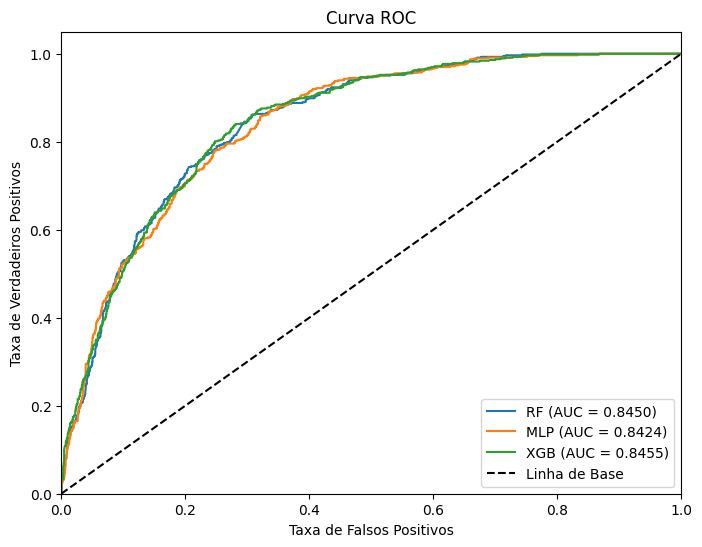

KS Statistic Random Forest: 0.5530693863519166
KS Statistic MLP: 0.5366137626769036
KS Statistic XGBoost: 0.5590110582707843


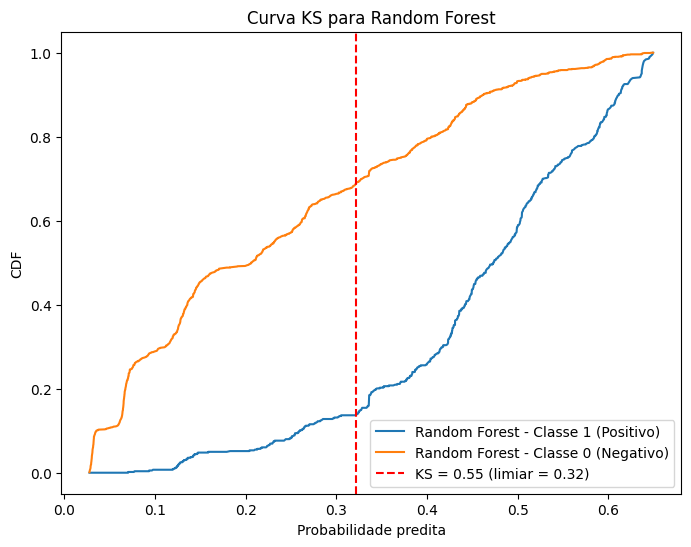

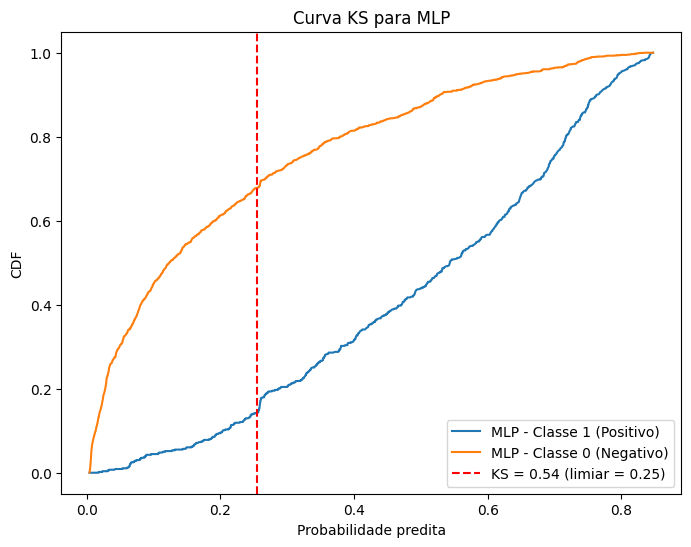

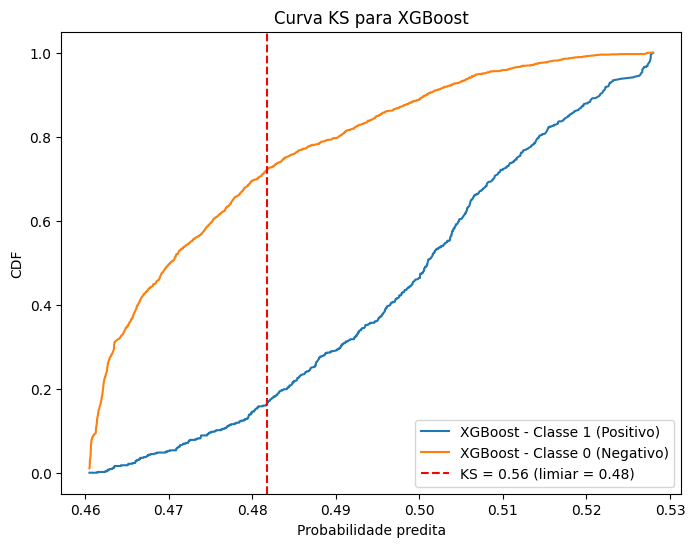

In [ ]:
# Combinar os conjuntos de treino e validação para treinar o modelo final
X_train_df = pd.DataFrame(X_train)
X_valid_df = pd.DataFrame(X_val)
X_train_final = pd.concat([X_train_df, X_valid_df], axis=0)

y_train_df = pd.DataFrame(y_train)
y_valid_df = pd.DataFrame(y_val)
y_train_final = pd.concat([y_train_df, y_valid_df], axis=0)

# --- Modelo Final: Random Forest ---
final_rf_model = RandomForestClassifier(random_state=42, **best_rf_params)
final_rf_model.fit(X_train_final, y_train_final)
rf_test_preds = final_rf_model.predict(X_test)
rf_test_accuracy = accuracy_score(y_test, rf_test_preds)
print("Final Random Forest Test Accuracy:", rf_test_accuracy)

# --- Modelo Final: MLPClassifier ---
final_mlp_model = MLPClassifier(random_state=42, **best_mlp_params)
final_mlp_model.fit(X_train_final, y_train_final)
mlp_test_preds = final_mlp_model.predict(X_test)
mlp_test_accuracy = accuracy_score(y_test, mlp_test_preds)
print("Final MLP Test Accuracy:", mlp_test_accuracy)

# --- Modelo Final: XGBoost ---
final_xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', **best_xgb_params)
final_xgb_model.fit(X_train_final, y_train_final)
xgb_test_preds = final_xgb_model.predict(X_test)
xgb_test_accuracy = accuracy_score(y_test, xgb_test_preds)
print("Final XGBoost Test Accuracy:", xgb_test_accuracy)
# Para métricas baseadas em probabilidades, obtemos as probabilidades da classe positiva:
xgb_probs = final_xgb_model.predict_proba(X_test)[:, 1]

# --- Avaliação com Curva ROC e KS Statistic ---
# Obter probabilidades preditas para a classe positiva ("Yes")
rf_probs = final_rf_model.predict_proba(X_test)[:, 1]
mlp_probs = final_mlp_model.predict_proba(X_test)[:, 1]
# (xgb_probs já foi obtido acima)

# Curva ROC para Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs, pos_label=1)
roc_auc_rf = auc(fpr_rf, tpr_rf)
# Curva ROC para MLP
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp_probs, pos_label=1)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)
# Curva ROC para XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs, pos_label=1)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plotar as curvas ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'RF (AUC = {roc_auc_rf:.4f})')
plt.plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC = {roc_auc_mlp:.4f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGB (AUC = {roc_auc_xgb:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Linha de Base')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# Cálculo do KS Statistic (comparando as probabilidades entre 1 e 0)
ks_rf = ks_2samp(rf_probs[y_test == 1], rf_probs[y_test == 0]).statistic
ks_mlp = ks_2samp(mlp_probs[y_test == 1], mlp_probs[y_test == 0]).statistic
ks_xgb = ks_2samp(xgb_probs[y_test == 1], xgb_probs[y_test == 0]).statistic

print("KS Statistic Random Forest:", ks_rf)
print("KS Statistic MLP:", ks_mlp)
print("KS Statistic XGBoost:", ks_xgb)

plot_ks(rf_probs, y_test, 'Random Forest')
plot_ks(mlp_probs, y_test, 'MLP')
plot_ks(xgb_probs, y_test, 'XGBoost')

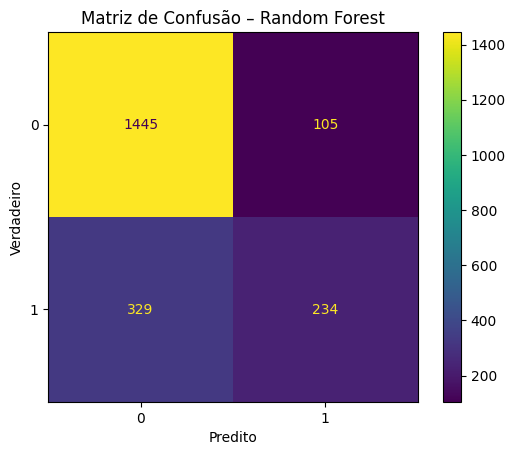

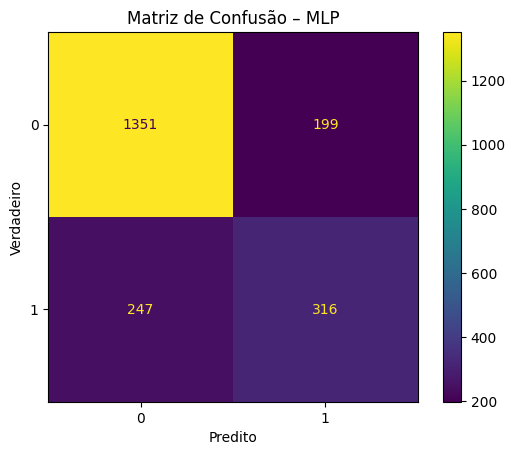

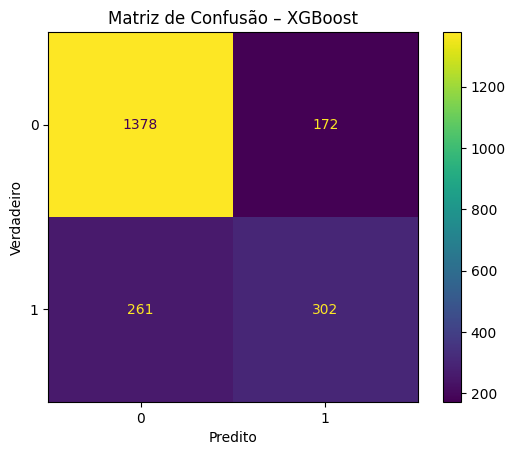

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# supondo que você já tenha:
# rf_test_preds, mlp_test_preds, xgb_test_preds
# y_test

# dicionário com rótulos e previsões
results = {
    "Random Forest": rf_test_preds,
    "MLP":           mlp_test_preds,
    "XGBoost":       xgb_test_preds
}

for name, preds in results.items():
    # calcula matriz de confusão
    cm = confusion_matrix(y_test, preds, labels=[0, 1])
    
    # plota
    fig, ax = plt.subplots()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=ax)
    
    ax.set_title(f"Matriz de Confusão – {name}")
    plt.xlabel("Predito")
    plt.ylabel("Verdadeiro")
    plt.show()
